Roadmap:
- eseguire il cluster vero e proprio con k=20-25
- eseguire il cluster nuovamente tramite sklearn ed identificare eventuali differenza
- fare la join con il dateset iniziale
- rispondere alle domande aggiuntive


In [120]:
import pandas as pd
import numpy as np
import scipy

from tqdm import tqdm

import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk import pos_tag

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import k_means
from sklearn.cluster import KMeans as SK_KMeans

import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing

In [2]:
#...

In [2]:
df = pd.read_csv("./data/CleanDatabase.csv")

In [3]:
df = df.groupby('ProductId', as_index = False).agg({'Text': ' '.join})

In [4]:
df.head()

,ProductId,Text
0,0006641040,days person say chicken soup probably go follo...
1,141278509X,product archer farm best drink mix ever mix fl...
2,2734888454,dog love chicken product china wont buy anymor...
3,2841233731,book easy read ingredients available store rec...
4,7310172001,product health snack pup make beef liver puppy...


# Tf-Idf Vectorizer

In [5]:
tf_idf = TfidfVectorizer(max_features=30000, stop_words='english', use_idf=True).fit_transform(df["Text"])

In [6]:
var_tfidf = 0
for i in range(tf_idf.shape[0]):
    var_tfidf += np.var(tf_idf[i].todense())
var_tfidf

2.4718108140800035

# TruncatedSVD

In [36]:
def best_compenents(tf_idf, n_components_initial, n_components_final, goal):
    variance_init = 0
    k = n_components_initial
    max_k = np.INF
    
    while n_components_initial <= k < n_components_final:
        svd = TruncatedSVD(n_components=k)
        svd.fit(tf_idf)
        
        variance = float(np.sum(svd.explained_variance_ratio_)*100)
        print(variance, k)
        
        if goal < variance < goal + 1:
            break
            
        if variance < goal:
            if k*2 > max_k:
                k += max_k
                k = k >> 1
            else:
                k *= 2
        else:
            k = k >> 2
            k *= 3 
            
    return k

In [7]:
n_best_components = 950 # best_compenents(tf_idf, 100, 10000, 60)
svd = TruncatedSVD(n_components=n_best_components)
X = svd.fit_transform(tf_idf)

In [9]:
X.shape, X

((74258, 950),
 array([[ 1.94887531e-01, -5.87168357e-02, -1.90294924e-02, ...,
          1.40779586e-02,  3.25757421e-02, -5.86725016e-03],
        [ 1.48120329e-01, -1.05293931e-02, -6.57476472e-06, ...,
          9.17394958e-03,  7.35322890e-03, -3.04100942e-04],
        [ 1.51334423e-01, -1.09013685e-01, -1.33395812e-01, ...,
         -1.61290657e-02,  1.00792057e-02, -1.72006200e-02],
        ...,
        [ 4.43693016e-02, -3.87353410e-03,  3.06819785e-03, ...,
          1.06278796e-02,  5.39511393e-03, -7.22674864e-03],
        [ 1.39601812e-01, -4.33366834e-02, -9.32850779e-03, ...,
         -2.21896071e-02,  8.33944500e-03,  1.76864751e-02],
        [ 1.13108080e-01, -3.50728109e-02, -1.06110823e-03, ...,
         -1.85487919e-02,  5.06883931e-03,  8.95991043e-03]]))

In [40]:
# np.savetxt("./data/X.txt", X)

# KMeans
#### K-Means Clustering 
1. Choose the number of clusters(K) and obtain the data points 
2. Place the centroids c_1, c_2, ..... c_k randomly 
3. Repeat steps 4 and 5 until convergence or until the end of a fixed number of iterations
4. for each data point x_i:
       - find the nearest centroid(c_1, c_2 .. c_k) 
       - assign the point to that cluster 
5. for each cluster j = 1..k
       - new centroid = mean of all points assigned to that cluster
6. End

In [84]:
class KMeans:
    def __init__(self, K, n_features, random_state=None):
        if random_state:
            np.random.seed(seed=random_state)
        self.K = K
        self.f = n_features
        self.centroids = (np.random.rand(K, n_features) - 0.5) * 100 #Value between -50 <= x < 50
        
    def fit(self, X, max_iter = 300):
        X_size = X.shape[0]
        U_old = np.zeros(X_size)
        U = np.zeros(X_size)
        
        for i in range(max_iter):
            U_old = np.copy(U)
            U, inertia = self.predict(X, inertia=True)
            
            for j in range(self.K):
                filt = U == j
                if filt.any():
                    self.centroids[j] = np.mean(X[filt], axis=0)
            
            if (U == U_old).all(): # Converge
                return inertia
            
            print('Iter:', i, 'Inerzia:', inertia, 'N. Changes:', np.sum(U != U_old))
            
        return inertia
    
    def calc_inertia(self, X):
        return self.predict(X, inertia=True)[1]
    
    def predict(self, X, inertia=False):
        n = X.shape[0]
        # 
        # _D = []
        # for i in range(self.K):
        #     _c =  self.centroids[i]
        #     _d = X - _c
        #     _D.append(np.linalg.norm(_d, axis=1))
        # _D = np.array(_D).T
        # 
        # res = np.argmin(_D, axis=1)
        
        res = np.zeros(X.shape[0])
        dist = np.zeros((n, self.K))
        iner = np.zeros(n)
        for i in range(X.shape[0]):
            x = X[i]
            min_dist = np.inf
            for j in range(self.K):
                dist[i,j] = scipy.spatial.distance.euclidean(x, self.centroids[j])
                # if dist[i,j] < min_dist:
                #     res[i] = j
                #     iner[i] = dist[i,j]
                #     min_dist = dist[i,j]
        
        res_2 = np.argmin(dist, axis=1)
        
        if (res != res_2).any():
            print('Ci sono problemi')
        
        if inertia:
            #_inertia = np.sum(np.take_along_axis(_D, np.expand_dims(res, axis=-1), axis=-1))
            #return res, _inertia
            #_inertia = np.sum(np.take_along_axis(dist, np.expand_dims(res, axis=-1), axis=-1))
            return res, np.sum(iner)
        
        return res

In [8]:
K = 20
max_iter = 300
#our_kMeans = KMeans(K, n_best_components)
sk_kMeans = SK_KMeans(n_clusters=K, max_iter=max_iter)

In [9]:
#our_inertia = our_kMeans.fit(X, max_iter=max_iter)
sk_kMeans.fit(X)
# sk_inertia = k_means(X, K, max_iter=max_iter, verbose=True)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=20, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [18]:
_, our_inertia = our_kMeans.predict(X, True)

In [80]:
sk_prediction = sk_kMeans.predict(X)

In [82]:
np.unique(sk_prediction, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 array([  441,   864,  1505, 32746,  3915,  1100, 10135,  2431,  1773,
         2366,   895,  3886,  2497,   712,   229,  3415,  2004,  1758,
          456,  1130], dtype=int64))

In [17]:
our_inertia

True

In [ ]:
our_inertia, sk_inertia

In [27]:
_X = X[:]
_X.shape

(74258, 950)

In [32]:
l = [2, 4, 6, 8, 10, 12, 15, 17, 20, 23, 27, 31, 38, 45, 52, 60, 75, 90, 110, 150, 200]

100%|███████████████████████████████████████████████████████████████████████████████| 21/21 [2:26:49<00:00, 419.48s/it]


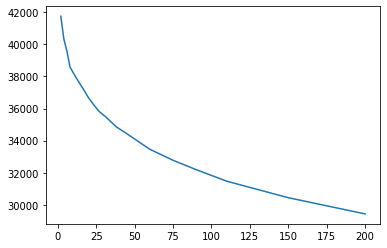

In [33]:
elbow = {}
for k in tqdm(l):
    elbow_model = SK_KMeans(n_clusters=k)
    elbow_model.fit_predict(_X)
    elbow[k] = elbow_model.inertia_ # inertia = sum of squared distances of samples to their closest cluster center
    
# for k in tqdm(range(50, 201, 25)):
#     elbow_model = SK_KMeans(n_clusters=k)
#     elbow_model.fit_predict(_X)
#     elbow[k] = elbow_model.inertia_ # inertia = sum of squared distances of samples to their closest cluster center
    
plt.plot(list(elbow.keys()), list(elbow.values()))


In [54]:
X

array([[ 1.94887531e-01, -5.87168357e-02, -1.90294925e-02, ...,
        -2.02419821e-02, -3.34133749e-02,  1.06753814e-03],
       [ 1.48120329e-01, -1.05293931e-02, -6.57477170e-06, ...,
        -1.26133500e-02,  8.01371409e-03,  1.03209963e-02],
       [ 1.51334423e-01, -1.09013685e-01, -1.33395812e-01, ...,
         1.58058832e-02, -1.51202133e-02,  7.94128817e-03],
       ...,
       [ 4.43693016e-02, -3.87353410e-03,  3.06819785e-03, ...,
         4.43489258e-03, -7.73628257e-03,  1.68864628e-02],
       [ 1.39601812e-01, -4.33366834e-02, -9.32850777e-03, ...,
         3.13507848e-02,  1.51967052e-03, -4.14573539e-02],
       [ 1.13108080e-01, -3.50728109e-02, -1.06110823e-03, ...,
         1.15547431e-02,  3.02739752e-03,  5.66844116e-03]])

In [34]:
elbow

{2: 41751.43134483724,
 4: 40329.381990624475,
 6: 39570.10930757552,
 8: 38584.125634933655,
 10: 38243.23251313096,
 12: 37919.936974100594,
 15: 37457.5397798227,
 17: 37159.64518375467,
 20: 36673.78676427781,
 23: 36284.27161604379,
 27: 35810.771976734286,
 31: 35502.317411071366,
 38: 34864.89631815433,
 45: 34426.79435320746,
 52: 33972.02166589827,
 60: 33455.50078864582,
 75: 32774.2817165911,
 90: 32191.979546429324,
 110: 31467.504530706166,
 150: 30441.23201402301,
 200: 29430.678709622152}

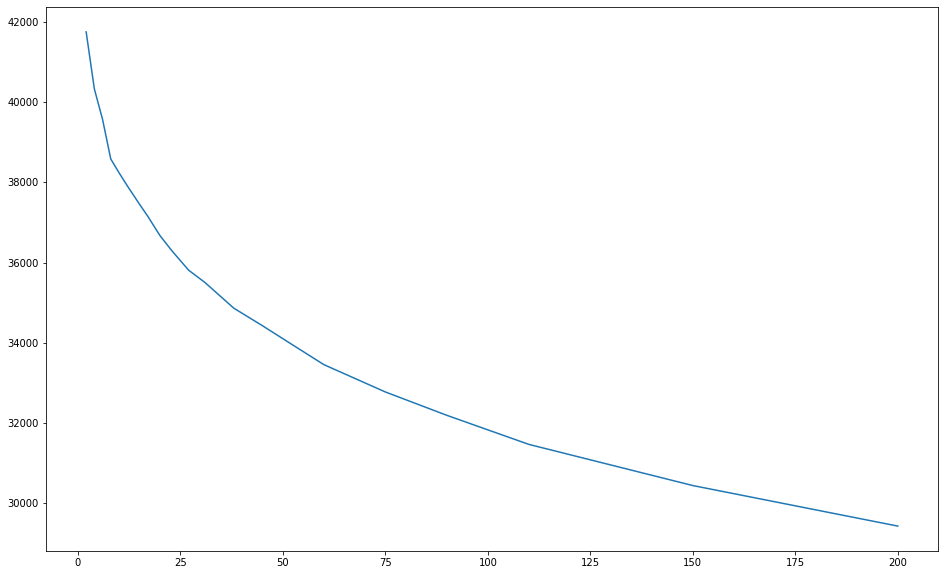

In [36]:
plt.figure(figsize=(16,10))
plt.plot(list(elbow.keys()), list(elbow.values()))

Text(30, 38000, 'Cluster Size')

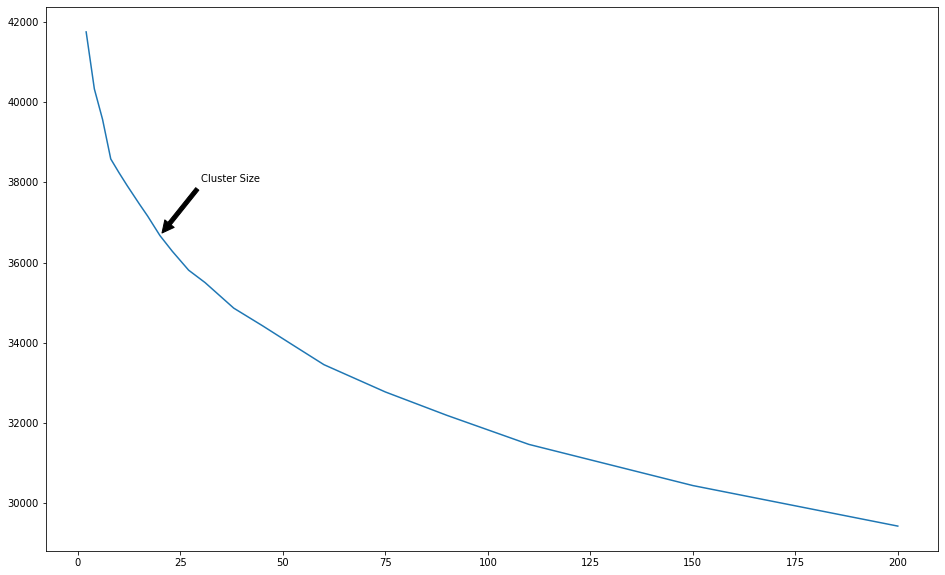

In [39]:
plt.figure(figsize=(16,10))
plt.plot(list(elbow.keys()), list(elbow.values()))
plt.annotate('Cluster Size', xy=(20, elbow[20]), xytext=(30,38000), arrowprops=dict(facecolor='black', shrink=0.05))

In [86]:
# %%time
model = KMeans(K, n_best_components)

In [87]:
X

array([[ 1.94887531e-01, -5.87168357e-02, -1.90294925e-02, ...,
        -2.02419821e-02, -3.34133749e-02,  1.06753814e-03],
       [ 1.48120329e-01, -1.05293931e-02, -6.57477170e-06, ...,
        -1.26133500e-02,  8.01371409e-03,  1.03209963e-02],
       [ 1.51334423e-01, -1.09013685e-01, -1.33395812e-01, ...,
         1.58058832e-02, -1.51202133e-02,  7.94128817e-03],
       ...,
       [ 4.43693016e-02, -3.87353410e-03,  3.06819785e-03, ...,
         4.43489258e-03, -7.73628257e-03,  1.68864628e-02],
       [ 1.39601812e-01, -4.33366834e-02, -9.32850777e-03, ...,
         3.13507848e-02,  1.51967052e-03, -4.14573539e-02],
       [ 1.13108080e-01, -3.50728109e-02, -1.06110823e-03, ...,
         1.15547431e-02,  3.02739752e-03,  5.66844116e-03]])

In [88]:
our_inertia = model.fit(X*100)

Inizio iterazione  0
U [ 1.  0. 14. ...  1.  9.  9.] U_old [0. 0. 0. ... 0. 0. 0.] N. Changes: 69932
(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19.]), array([ 4326, 10804,  2739,  1314,  1128,  4560,  2088,  3192,  1792,
        3018,  5370,  5843,  2523,  4075,  3923,  6425,  1799,   609,
        5907,  2823], dtype=int64))
Fine predict
Fine update
Fine controllo di convergenza
Iter: 0 Inerzia: 5861923.720607534
Inizio iterazione  1
U [18.  1. 10. ... 16.  3.  0.] U_old [ 1.  0. 14. ...  1.  9.  9.] N. Changes: 54088
(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19.]), array([7922, 4817, 4925, 6092, 1983,  647, 1852, 6122, 2600, 2985, 4842,
       3172, 3585, 3398, 1881, 1250, 6163, 1008, 3388, 5626], dtype=int64))
Fine predict
Fine update
Fine controllo di convergenza
Iter: 1 Inerzia: 5431087.079502913
Inizio iterazione  2
U [18.  1. 10. ... 16.  3. 16.] 

Fine update
Fine controllo di convergenza
Iter: 16 Inerzia: 5141033.796278571
Inizio iterazione  17
U [18.  1. 10. ... 16. 16.  3.] U_old [18.  1. 10. ... 16. 16.  3.] N. Changes: 615
(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19.]), array([ 2470,  2675,  3851,  8670,  1781,   690,   724,  6096,  1761,
        1484,  3887,  5101,  2388,  2901,   620,   851, 21121,  1209,
        1121,  4857], dtype=int64))
Fine predict
Fine update
Fine controllo di convergenza
Iter: 17 Inerzia: 5140911.996784322
Inizio iterazione  18
U [18.  1. 10. ... 16. 16.  3.] U_old [18.  1. 10. ... 16. 16.  3.] N. Changes: 580
(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19.]), array([ 2473,  2712,  3850,  8652,  1721,   689,   725,  6192,  1761,
        1479,  3888,  4931,  2378,  2904,   617,   810, 21290,  1208,
        1120,  4858], dtype=int64))
Fine predict
Fine update
Fine con

Fine update
Fine controllo di convergenza
Iter: 33 Inerzia: 5134931.47384809
Inizio iterazione  34
U [18.  1. 10. ... 16. 16.  3.] U_old [18.  1. 10. ... 16. 16.  3.] N. Changes: 161
(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19.]), array([ 2451,  3427,  3836,  9032,   908,   691,   732,  6903,  1759,
        1456,  3893,  3314,  2376,  2926,   617,   452, 22294,  1219,
        1118,  4854], dtype=int64))
Fine predict
Fine update
Fine controllo di convergenza
Iter: 34 Inerzia: 5134921.351074662
Inizio iterazione  35
U [18.  1. 10. ... 16. 16.  3.] U_old [18.  1. 10. ... 16. 16.  3.] N. Changes: 183
(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19.]), array([ 2450,  3463,  3834,  9038,   907,   691,   732,  6933,  1759,
        1456,  3893,  3226,  2372,  2923,   616,   452, 22319,  1219,
        1119,  4856], dtype=int64))
Fine predict
Fine update
Fine cont

Fine update
Fine controllo di convergenza
Iter: 50 Inerzia: 5134914.290220829
Inizio iterazione  51
U [18.  1. 10. ... 16. 16.  3.] U_old [18.  1. 10. ... 16. 16.  3.] N. Changes: 5
(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19.]), array([ 2445,  3687,  3831,  9061,   907,   691,   734,  7002,  1759,
        1453,  3895,  2964,  2365,  2924,   615,   452, 22277,  1219,
        1117,  4860], dtype=int64))
Fine predict
Fine update
Fine controllo di convergenza
Iter: 51 Inerzia: 5134914.82601861
Inizio iterazione  52
U [18.  1. 10. ... 16. 16.  3.] U_old [18.  1. 10. ... 16. 16.  3.] N. Changes: 2
(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19.]), array([ 2445,  3689,  3831,  9061,   907,   691,   734,  7002,  1759,
        1453,  3895,  2964,  2365,  2924,   615,   452, 22275,  1219,
        1117,  4860], dtype=int64))
Fine predict
Fine update
Fine controll

In [91]:
%%time
pred, our_inertia = model.predict(X*100, True)

Wall time: 28.2 s


In [92]:
np.unique(pred, return_counts=True)

(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19.]),
 array([ 2445,  3689,  3831,  9061,   907,   691,   734,  7002,  1759,
         1453,  3895,  2964,  2365,  2924,   615,   452, 22275,  1219,
         1117,  4860], dtype=int64))

* creiamo i cluster
* groupby sui cluster
* join sui text
* countVect per ogni cluster
* stampiamo la wordcloud e poi faccia le considerazioni


In [93]:
#df['Cluster'] = model.predict(X)
df['Cluster'] = pred

In [94]:
df

,ProductId,Text,Cluster
0,0006641040,days person say chicken soup probably go follo...,18.0
1,141278509X,product archer farm best drink mix ever mix fl...,1.0
2,2734888454,dog love chicken product china wont buy anymor...,10.0
3,2841233731,book easy read ingredients available store rec...,11.0
4,7310172001,product health snack pup make beef liver puppy...,10.0
...,...,...,...
74253,B009UOFTUI,coffee supposedly premium taste watery thin go...,1.0
74254,B009UOFU20,coffee supposedly premium taste watery thin go...,1.0
74255,B009UUS05I,basket perfect sympathy gift try express much ...,16.0
74256,B009WSNWC4,purchase product local store ny kid love quick...,16.0


In [ ]:
product_cluster = df.set_index('ProductId')['Cluster']

In [95]:
reviews = pd.read_csv('./data/Reviews.csv')

In [106]:
rev_complete = reviews.join(product_cluster, on='ProductId')

In [116]:
df = pd.DataFrame(df)

In [119]:
# risposta alla 2.3.2
df.groupby('Cluster').size()

Cluster
0.0      2445
1.0      3689
2.0      3831
3.0      9061
4.0       907
5.0       691
6.0       734
7.0      7002
8.0      1759
9.0      1453
10.0     3895
11.0     2964
12.0     2365
13.0     2924
14.0      615
15.0      452
16.0    22275
17.0     1219
18.0     1117
19.0     4860
dtype: int64

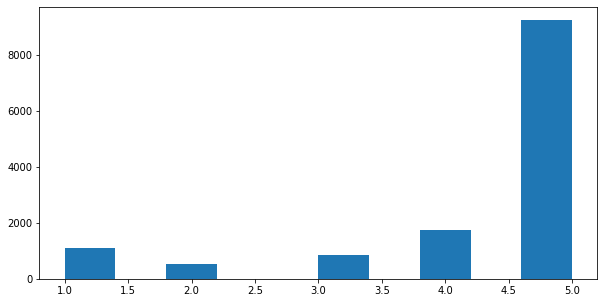

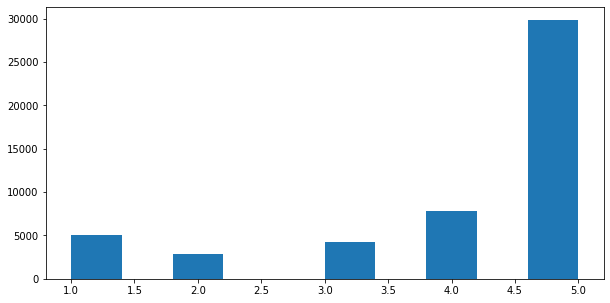

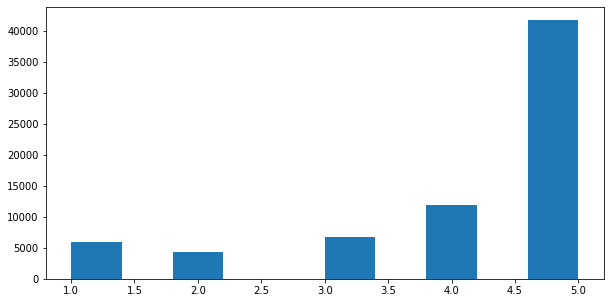

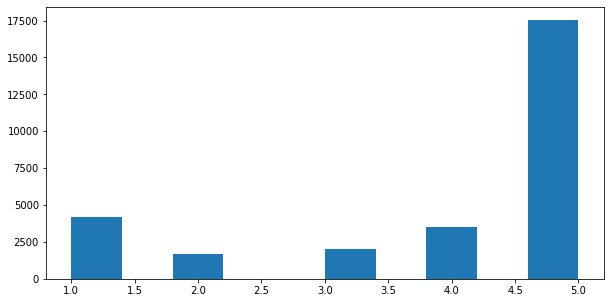

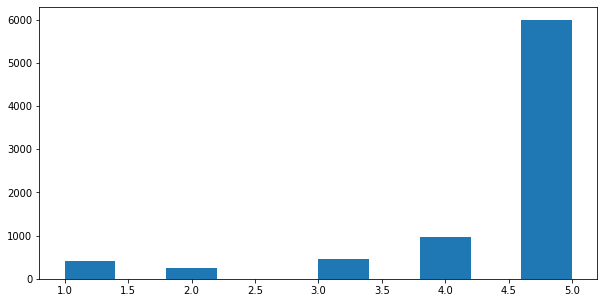

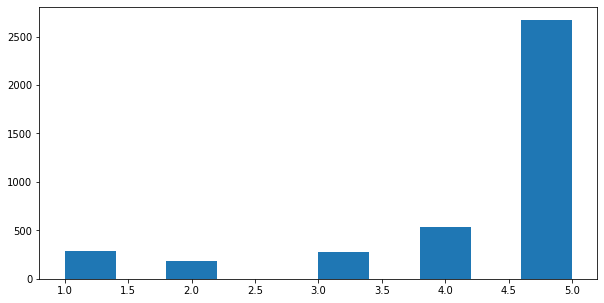

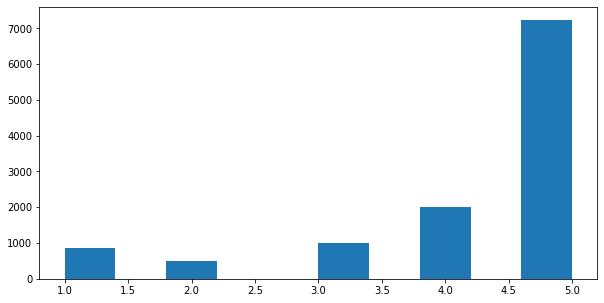

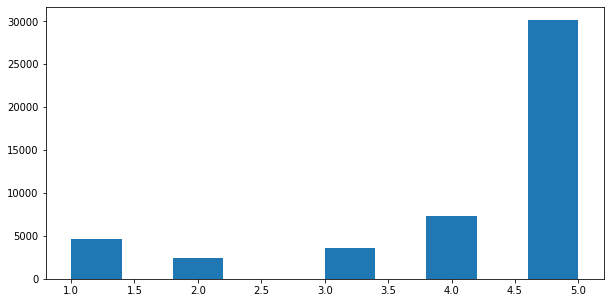

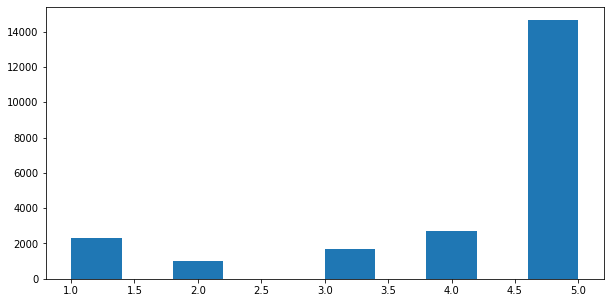

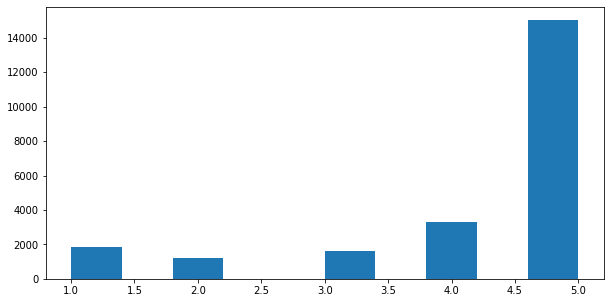

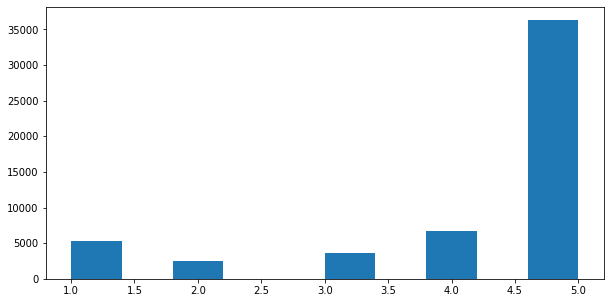

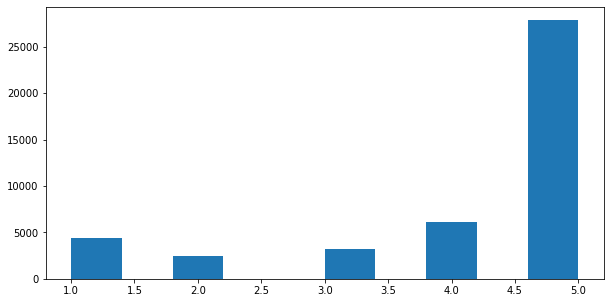

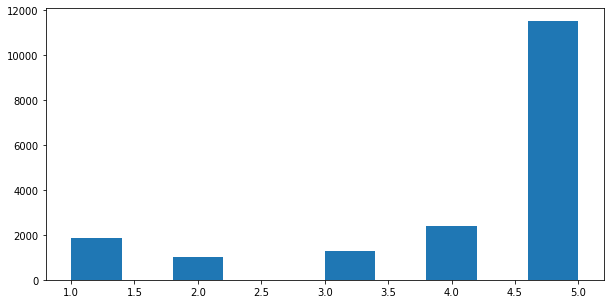

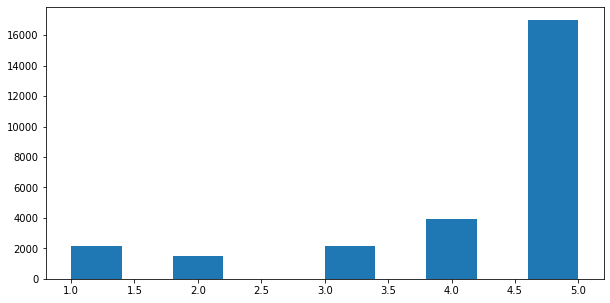

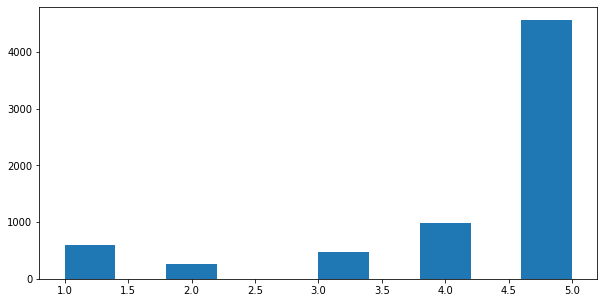

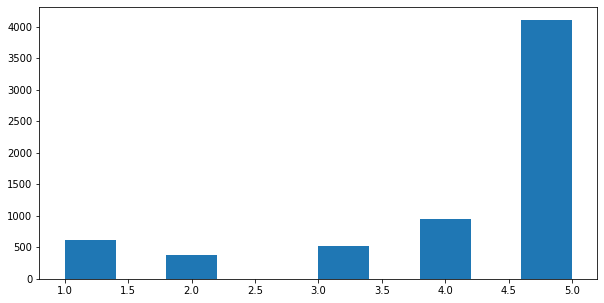

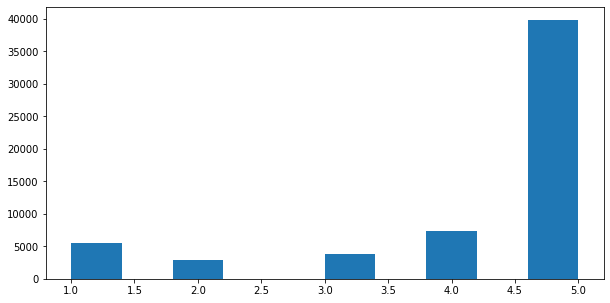

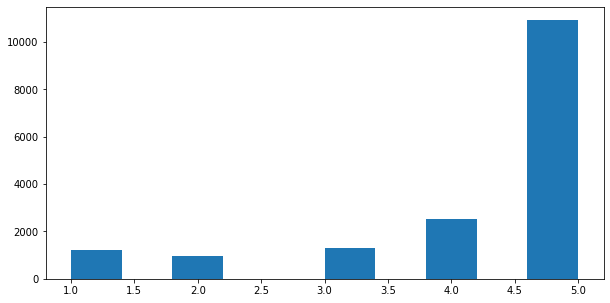

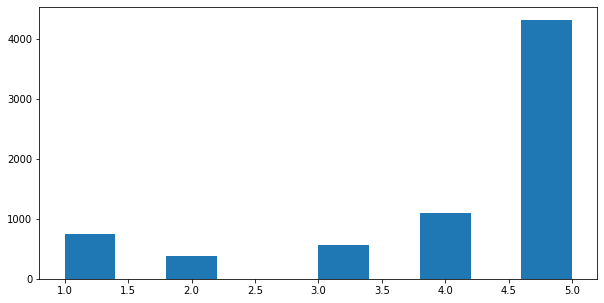

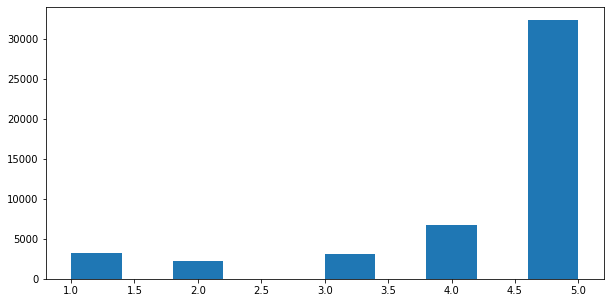

In [127]:
# 2.3.3

#score = rev_complete.groupby('Cluster', as_index = False)
#sns.histplot(data=score, x='Score')

for cluster in range(K):
    fig = plt.figure(figsize=(10,5))
    plt.hist(rev_complete[rev_complete.Cluster == cluster].Score)
    plt.show()



In [129]:
# 2.3.4
rev_complete.groupby('Cluster').UserId.nunique()

Cluster
0.0     10983
1.0     30158
2.0     32693
3.0     24611
4.0      6126
5.0      3560
6.0      8054
7.0     33274
8.0      8811
9.0      7182
10.0    21038
11.0    22088
12.0    12401
13.0    16255
14.0     4805
15.0     3890
16.0    46472
17.0     7707
18.0     5682
19.0    24505
Name: UserId, dtype: int64